In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm import tqdm

from bnn import DummyBNN
from adaptive_sghmc_v2 import AdaptiveSGHMC
from sghmc import SGHMC

%matplotlib inline

tfd = tfp.distributions
tfl = tf.keras.layers

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)

#plt.rc("text", usetex=True)
plt.rc("font", size=32.0, family="serif")
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
def f(x):
    return np.sinc(x * 10. - 5.)

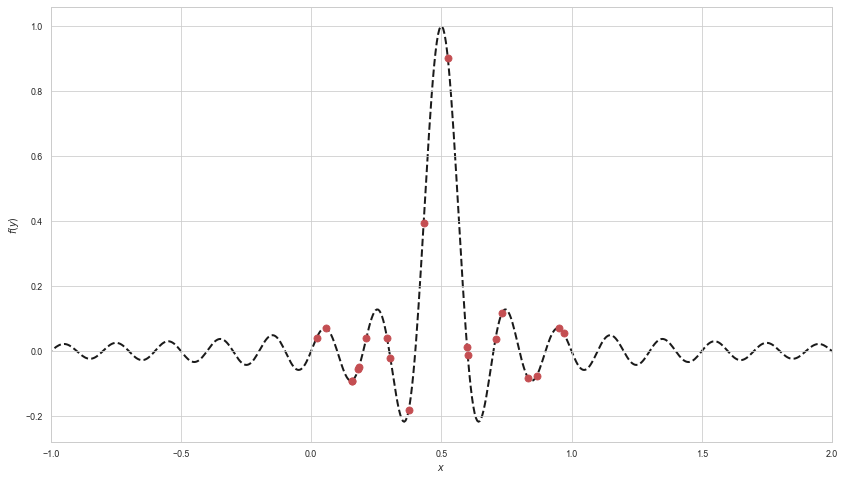

In [4]:
rng = np.random.RandomState(42)

num_points = 20

x = rng.rand(num_points).astype(np.float32)
y = f(x)

grid = np.linspace(-2., 3., 1000).astype(np.float32)
fvals = f(grid)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=1, s=50)

ax.set_xlim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

In [5]:
bnn = DummyBNN()
bnn.build(input_shape=(None, 1))

In [6]:
@tf.function
def train_step(model, batch, labels):

    with tf.GradientTape() as tape:
        
        data_size = tf.cast(num_points, tf.float32)
        
        pred = model(batch)
        
        likelihood = tfd.Normal(loc=pred, scale=tf.exp(0.5 * model.likelihood_log_var))
        log_likelihood = tf.reduce_mean(likelihood.log_prob(labels))
        
        var_prior_log_prob = model.var_prior.log_prob(tf.exp(model.likelihood_log_var)) / data_size
        
        weight_prior_log_prob = model.weight_prior_log_prob() / data_size
        
        loss = -(log_likelihood + weight_prior_log_prob + var_prior_log_prob)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return pred, log_likelihood, var_prior_log_prob, weight_prior_log_prob

In [7]:
batch_size = num_points
iterations = 20000
keep_every = 50
burnin = 2000
learning_rate = 1e-2
friction = 0.05

log_every = 2000

x_mean, x_var = tf.nn.moments(tf.convert_to_tensor(x), axes=[0])
x_std = tf.sqrt(x_var)
y_mean, y_var = tf.nn.moments(tf.convert_to_tensor(y), axes=[0])
y_std = tf.sqrt(y_var)

x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

ds = tf.data.Dataset.from_tensor_slices((x_normalized[:, None], y_normalized[:, None]))
ds = ds.shuffle(500).repeat().batch(batch_size).prefetch(16)

optimizer = {
    "adaptive_sghmc": AdaptiveSGHMC(learning_rate=learning_rate,
                                    burnin=burnin,
                                    data_size=num_points,
                                    overestimation_rate=3.,
                                    initialization_rounds=10,
                                    friction=friction),
    
    "sghmc": SGHMC(learning_rate=1e-6,
                   data_size=num_points,
                   momentum_decay=friction),
    
    "adam": tf.optimizers.Adam(learning_rate=1e-3),
}["adaptive_sghmc"]

In [8]:
weight_samples = []

i = 0

for batch, labels in tqdm(ds.take(iterations), total=iterations):

    i = i + 1

    pred, ll, vplp, wplp = train_step(bnn,
                                      batch, 
                                      labels)
    
    if i >= burnin and i % keep_every == 0:
        weight_samples.append(bnn.get_weights())
        
    if i % log_every == 0:
        mse = tf.reduce_mean(tf.math.squared_difference(pred, labels))
        
        print(f"iteration {i}: "
              f"MSE: {mse:.6f}, "
              f"LL: {ll:.6f}, "
              f"weight prior LL: {wplp:.6f}, "
              f"var prior LL: {vplp:.6f}")

  0%|          | 1/20000 [00:02<13:11:27,  2.37s/it]

SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!


 10%|█         | 2072/20000 [00:06<00:32, 543.72it/s]

iteration 2000: MSE: 0.003275, LL: -1.156358, weight prior LL: -1.337637, var prior LL: -4.237895


 21%|██        | 4102/20000 [00:09<00:28, 562.60it/s]

iteration 4000: MSE: 0.006833, LL: -12.633141, weight prior LL: -1.963201, var prior LL: -0.961909


 31%|███       | 6114/20000 [00:13<00:23, 603.15it/s]

iteration 6000: MSE: 0.000577, LL: 2.129375, weight prior LL: -2.142674, var prior LL: -2.058008


 41%|████      | 8105/20000 [00:16<00:20, 572.85it/s]

iteration 8000: MSE: 0.000098, LL: 3.196444, weight prior LL: -2.214498, var prior LL: 0.525533


 50%|█████     | 10059/20000 [00:20<00:17, 573.03it/s]

iteration 10000: MSE: 0.000058, LL: 3.405147, weight prior LL: -2.336397, var prior LL: 0.527797


 60%|██████    | 12072/20000 [00:23<00:13, 580.99it/s]

iteration 12000: MSE: 0.000051, LL: 3.408511, weight prior LL: -2.510177, var prior LL: 0.504963


 71%|███████   | 14103/20000 [00:27<00:09, 593.22it/s]

iteration 14000: MSE: 0.000337, LL: 2.326972, weight prior LL: -2.754189, var prior LL: 0.194577


 80%|████████  | 16077/20000 [00:30<00:06, 582.70it/s]

iteration 16000: MSE: 0.000278, LL: 2.343824, weight prior LL: -2.791260, var prior LL: 0.518575


 90%|█████████ | 18075/20000 [00:33<00:03, 624.27it/s]

iteration 18000: MSE: 0.000223, LL: 2.597486, weight prior LL: -2.860398, var prior LL: 0.523046


100%|██████████| 20000/20000 [00:36<00:00, 543.75it/s]

iteration 20000: MSE: 0.000173, LL: 2.869440, weight prior LL: -3.064717, var prior LL: 0.461726


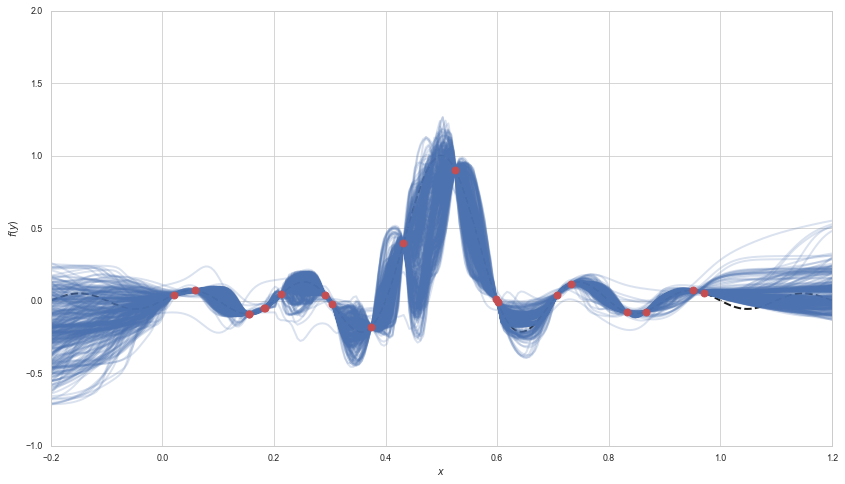

In [9]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

all_preds = []

for weights in weight_samples[:]:
    
    bnn.set_weights(weights)
    
    pred = bnn((grid[:, None] - x_mean) / x_std).numpy()[:, 0]
    pred = y_std * pred + y_mean
    
    ax.plot(grid, pred, c='b', alpha=0.2, zorder=1)
    
    all_preds.append(pred)

all_preds = tf.stack(all_preds, axis=0)

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=2, s=50)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.savefig("samples.png")

plt.show()

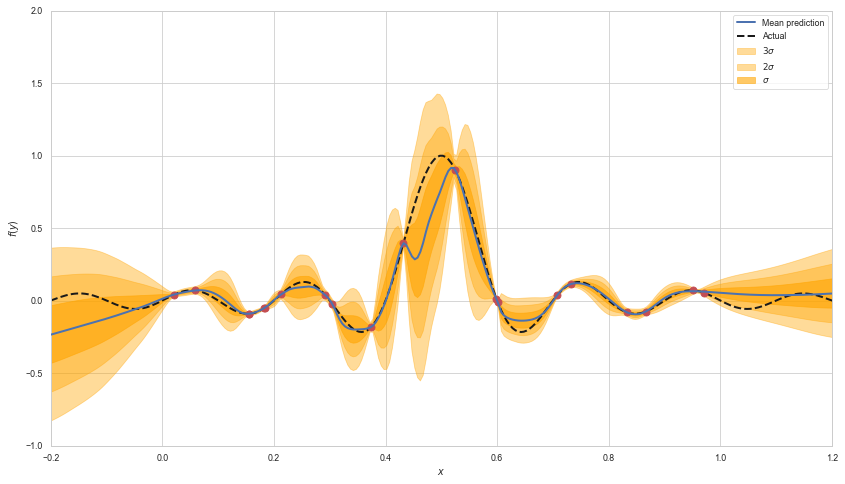

In [10]:
mean_pred, var_pred = tf.nn.moments(all_preds[30:, :], axes=[0])

fig, ax = plt.subplots(figsize=(14, 8))

std_pred = tf.sqrt(var_pred)

ax.plot(grid, mean_pred, linestyle='-', c='b', zorder=4, label="Mean prediction")
ax.fill_between(grid, 
                mean_pred + 3. * std_pred, 
                mean_pred - 3. * std_pred, 
                alpha=0.4, label="$3\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + 2. * std_pred, 
                mean_pred - 2. * std_pred, 
                alpha=0.4, label="$2\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + std_pred, 
                mean_pred - std_pred, 
                alpha=0.6, label="$\sigma$", color='orange')

ax.plot(grid, fvals, linestyle='--', c='k', zorder=2, label="Actual")
ax.scatter(x, y, marker='o', c='r', zorder=3, s=50)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

ax.legend()

plt.savefig("statistics.png")

plt.show()